[1] 모듈 로딩 및 데이터 준비
- 모듈 로딩
- 데이터 준비
- 피처와 타겟 개수 확인
- 분류 확인
<hr>

[2] 데이터 가공 및 전처리
- 결측치 / 중복 / 이상치 => 없음
- 다중 분류 ▶ 이진 분류 변환 => 타겟 변환
- 표준화 => 이미지 동일 크기 및 색상 채널 : 동일 크기(28*28)와 채널(흑백1) 
- 정규화 => 피처 정규화 / 타겟 정규화
<hr>

[3] 학습 준비
- 텐서화
- 데이터셋 준비 : 훈련용, 테스트용
- 학습 방법 : 지도 학습 ( 이진 분류 ) => Linear 클래스 + Sigmoid 함수
- 최적화 방법 : 경사하강법 기반 => adam, SDG    
- 손실 함수 : 이진분류 손실 계산 함수 => binary_cross_entropy
<hr>

[4] 학습
- 반복 횟수만큼 학습 진행. 
<hr>

[1] 모듈 로딩 및 데이터 준비

In [2]:
# 모듈 로딩
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

import torch
import torch.nn as nn               # LinearRegression 기능의 클래스 linear
import torch.nn.functional as F     # 손실함수
import torch.optim as optim         # 경사하강법 기반의 최적화 관련 모듈

In [3]:
# 데이터 준비
fashion_db = 'fashion-mnist'

fashion_data = fetch_openml(name=fashion_db, parser='auto') 
# as_frame = True로 설정해도 데이터프레임으로 만들어지지 않을 때도 있다.
# 그럴 때는 직접 변환하면 된다.

In [4]:
type(fashion_data)

sklearn.utils._bunch.Bunch

In [5]:
feature = fashion_data['data']
target = fashion_data['target']

In [6]:
# 피처와 타겟 개수 확인

print(f'features => {feature.shape}, {feature.ndim}D') 
print(f'target => {target.shape}, {target.ndim}D') 

features => (70000, 784), 2D
target => (70000,), 1D


In [7]:
# 분류 확인
print(f'feature => {fashion_data["feature_names"]}')
print(f'target => {fashion_data["target_names"]}')
print(f'categories => {fashion_data["categories"]}') # None
print(f'CATEGORIES => {target.unique()}') 

feature => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel9

[2] 데이터 가공 및 전처리 <hr>

In [8]:
# [2-1] 다중 분류 ▶ 이진 분류 변환 => 타겟 변환

target = (target =='0')

target.unique()
target

0        False
1         True
2         True
3        False
4         True
         ...  
69995    False
69996    False
69997    False
69998    False
69999    False
Name: class, Length: 70000, dtype: bool

In [9]:
# [2-2] 정규화 => 피처  :785개 색상값 즉 0~255 범위 값
normFeature=feature/255. # 정수 / 실수 ==> 실수로 형변환하여 나눗셈 실행.
normFeature.head(2)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.0,0.0,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# [2-2] 정규화 => 타겟 : One-Hot Encoding으로 변환.
pd.get_dummies(target)

target, target.unique()

(0        False
 1         True
 2         True
 3        False
 4         True
          ...  
 69995    False
 69996    False
 69997    False
 69998    False
 69999    False
 Name: class, Length: 70000, dtype: bool,
 array([False,  True]))

In [11]:
from sklearn.preprocessing import OneHotEncoder
targetDF = target.to_frame()
print(target.shape)

(70000,)


In [12]:
# 희소 행렬(sparse matrix) 형식으로 인코딩된 데이터를 원할 경우.
# 희소 행렬 : 대부분의 요소가 0으로 채워진 행렬을 의미
ohEncoder = OneHotEncoder() # sparse =True =--> 압축시켜서 줌.
ohEncoder.fit([target]) # 2차원 데이터
ohEncoder.transform([target]).toarray()

array([[1., 1., 1., ..., 1., 1., 1.]])

In [13]:
# 밀집 배열(dense array) 형식으로 인코딩된 데이터를 원할 경우.
ohEncoder = OneHotEncoder(sparse_output=False) # sparse =True =--> 압축시켜서 줌.
ohEncoder.fit(targetDF)
ohEncoder.categories_

[array([False,  True])]

In [14]:
norm_target = ohEncoder.transform(targetDF)
norm_target.shape, norm_target.ndim

((70000, 2), 2)

In [15]:
# 학습 준비

# 데이터셋 준비 : 6만 개 훈련, 1만 개 테스트.
limit = 60000
train = normFeature.iloc[:limit]
test = normFeature.iloc[limit:]
ytrain = target.iloc[:limit]
ytest = target.iloc[limit:]

print(f'train : {train.shape}, {train.ndim}D')
print(f'test : {test.shape}, {test.ndim}D')
print(f'ytrain : {ytrain.shape}, {ytrain.ndim}D')
print(f'ytest : {ytest.shape}, {ytest.ndim}D')

train : (60000, 784), 2D
test : (10000, 784), 2D
ytrain : (60000,), 1D
ytest : (10000,), 1D


In [16]:
# 텐서로 변환
Xtrn = torch.FloatTensor(train.values)
Xtst = torch.FloatTensor(test.values)
ytrn = torch.FloatTensor(ytrain.values).unsqueeze(dim=1)
ytst = torch.FloatTensor(ytest.values).unsqueeze(dim=1)

print(f'Xtrn : {Xtrn.shape}, {Xtrn.ndim}D')
print(f'Xtst : {Xtst.shape}, {Xtst.ndim}D')
print(f'ytrn : {ytrn.shape}, {ytrn.ndim}D')
print(f'ytst : {ytst.shape}, {ytst.ndim}D')

Xtrn : torch.Size([60000, 784]), 2D
Xtst : torch.Size([10000, 784]), 2D
ytrn : torch.Size([60000, 1]), 2D
ytst : torch.Size([10000, 1]), 2D


In [17]:
# 학습 인스턴스 생성
in_, out_ = Xtrn.shape[1], ytrn.shape[1]
in_, out_ # 피처 컬럼수. 출력차원 out은 타겟 컬럼수

(784, 1)

In [18]:
mdl = nn.Linear(in_, out_) # (피처 컬럼수, 타겟의 컬럼 수)
# y = wx +b # 몇 개의 피처를 넣어서 몇 개의 결과를 낼 건지 
# _를 넣은 이유는 연산자 충돌 일어날까봐..!

mdl 
# 784개를 받아서 1개를 반환 ===> w가 784개 생겨야 함. 파이썬이 알아서 계산해줄 것.

Linear(in_features=784, out_features=1, bias=True)

In [19]:
# 최적화 인스턴스 생성 => 모델에서 사용하는 w와 b 변수들 전달 
optimizer=optim.Adam(mdl.parameters()) 
# PyTorch에서 제공하는 옵티마이저인 Adam을 사용하여 모델의 파라미터를 업데이트

In [20]:
# 학습 횟수 => 샘플 처음부터 끝까지 읽는 것(에포크) 기준으로 회수 지정
EPOCHS = 150

In [21]:
ytrn.shape

torch.Size([60000, 1])

In [22]:
# 학습

In [23]:
loss_list = []
loss_accuracy = [[], []] # [0]에는 오차가 담기고 [1]에는 훈련 정확도가 입력됨.
for ep in range(EPOCHS):
    # 학습
    pre_y = mdl(Xtrn) 
    # pre_y = mdl(Xtrn)에서는 실제로 입력 데이터인 Xtrn을 사용하여 예측값을 계산
    # print(f"예측값 : {pre_y}")
    
    # 분류값 변화
    pre_y2 = F.sigmoid(pre_y)
    # 시그모이드 함수는 입력값을 [0, 1] 범위로 변환하는 비선형 함수.
    # 이 함수는 주로 이진 분류 문제에서 확률을 계산하기 위해 사용.
    #print(f"분류값 : {pre_y2}")
        
    # 오차 즉 손실 계산
    loss = F.binary_cross_entropy(pre_y2, ytrn) # (예측값, 정답)
    #loss_list.append(loss.item())
    loss_accuracy[0].append(loss.item())
    print(f'[{ep+1}] Loss => {loss}')
    
    # W, b 업데이트
    optimizer.zero_grad() # 초기화
    loss.backward()  # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
    optimizer.step() # 새로운 값으로 W, b 업데이트
    
    # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
    train_accuracy = ((ytrn == (pre_y2 >= 0.5)).sum() )/ ytrn.shape[0]
    # 예측값이 0.5보다 클 때의 정답의 값을 더한 것 / 60000
    loss_accuracy[1].append(train_accuracy) # 훈련용 데이터 정확도.

[1] Loss => 0.7540280222892761
[2] Loss => 0.6636289358139038
[3] Loss => 0.588546633720398
[4] Loss => 0.5282079577445984
[5] Loss => 0.4812043607234955
[6] Loss => 0.4456062614917755
[7] Loss => 0.4193081259727478
[8] Loss => 0.4002974033355713
[9] Loss => 0.3868069052696228
[10] Loss => 0.37737056612968445
[11] Loss => 0.37081876397132874
[12] Loss => 0.36624374985694885
[13] Loss => 0.3629560172557831
[14] Loss => 0.36044132709503174
[15] Loss => 0.3583223819732666
[16] Loss => 0.3563280701637268
[17] Loss => 0.35426855087280273
[18] Loss => 0.3520160913467407
[19] Loss => 0.3494899868965149
[20] Loss => 0.34664544463157654
[21] Loss => 0.3434649705886841
[22] Loss => 0.33995166420936584
[23] Loss => 0.3361242115497589
[24] Loss => 0.33201321959495544
[25] Loss => 0.32765793800354004
[26] Loss => 0.3231039345264435
[27] Loss => 0.31840115785598755
[28] Loss => 0.31360217928886414
[29] Loss => 0.30876055359840393
[30] Loss => 0.3039293885231018
[31] Loss => 0.2991601526737213
[32] L

In [28]:
pre_y.shape, pre_y2.shape, Xtrn.shape

(torch.Size([60000, 1]), torch.Size([60000, 1]), torch.Size([60000, 784]))

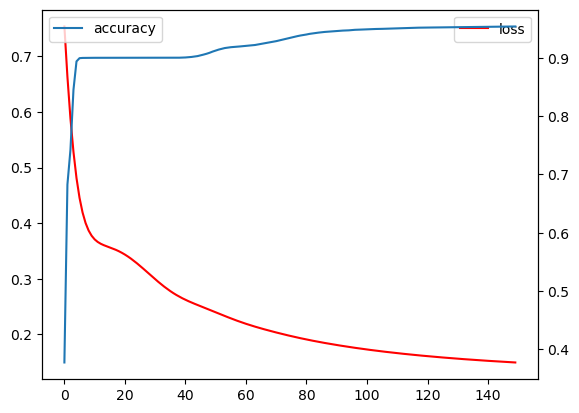

In [24]:
# 손실과 정확도 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots() # 큰 그림과 ax1이라는 subplot(1) 형성.
ax1.plot(loss_accuracy[0], label = 'loss', color = 'red')
ax2 = ax1.twinx() # ax1과 x 축을 공유하는 ax2라는 subplot(2)를 형성.
ax2.plot(loss_accuracy[1], label = 'accuracy')

ax1.legend()
ax2.legend()
plt.xlabel('Epochs')
plt.show()